    Survey Date      Total    Total Live    Total Dead    Live Chum    Live Coho    Dead Chum    Dead Coho    Remnant
--  -------------  -------  ------------  ------------  -----------  -----------  -----------  -----------  ---------
 7  2019-10-26          23             5            18            0            1            1           17          0
 9  2019-11-02           7             3             1            2            0            1            0          3
 8  2019-11-09          11             5             1            4            0            1            0          5
 6  2019-11-16          19            15             4            9            1            4            0          0
 5  2019-11-19           1             0             1            0            0            1            0          0
 4  2019-11-23          38            17            20           12            1           17            2          1
 3  2019-11-30          24            19             5  

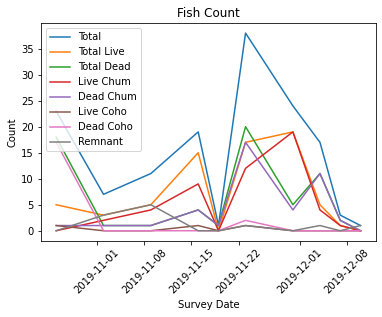

In [7]:
import requests, json, datetime, matplotlib.pyplot as plt, plotly.express as px, pandas as pd

def getEntries(uri):
    request = requests.get(url = uri)
    df = pd.DataFrame(pd.json_normalize(request.json()['data']['entries']))
    while request.json()['links']['next'] is not None:
        nextURL = request.json()['links']['next']
        request = requests.get(url = nextURL)
        df = df.append(pd.json_normalize(request.json()['data']['entries']))
    return df

def addStats(survey, salmonDf):
    surveyUUID = survey['ec5_uuid']
    todaySalmonDf = salmonDf[salmonDf['ec5_parent_uuid'] == surveyUUID] 
    deadChum = (todaySalmonDf.loc[((todaySalmonDf['12_Species'] == 'Chum') & (todaySalmonDf['16_Status'] == 'Dead'))].shape[0]) 
    deadCoho = (todaySalmonDf.loc[((todaySalmonDf['12_Species'] == 'Coho') & (todaySalmonDf['16_Status'] == 'Dead'))].shape[0])
    liveChum = (todaySalmonDf.loc[((todaySalmonDf['12_Species'] == 'Chum') & (todaySalmonDf['16_Status'] == 'Live'))].shape[0])
    liveCoho = (todaySalmonDf.loc[((todaySalmonDf['12_Species'] == 'Coho') & (todaySalmonDf['16_Status'] == 'Live'))].shape[0])
    remnant = todaySalmonDf.loc[(todaySalmonDf['16_Status'] == 'Remnant')].shape[0]
    totalDead = todaySalmonDf.loc[(todaySalmonDf['16_Status'] == 'Dead')].shape[0]
    totalLive = todaySalmonDf.loc[(todaySalmonDf['16_Status'] == 'Live')].shape[0]
    total = (todaySalmonDf.shape[0])
    statsRow = pd.Series({'Survey Date': datetime.datetime.strptime(survey['1_Survey_Date'], '%m/%d/%Y').date(), 'Dead Chum': deadChum, 'Dead Coho': deadCoho, 'Live Chum': liveChum, 'Live Coho': liveCoho, 'Remnant': remnant, 'Total Dead': totalDead, 'Total Live': totalLive, 'Total': total})
    global statsDf
    statsDf = statsDf.append(statsRow, ignore_index = True)
    
pd.set_option('display.precision', 0)
salmonFormURI = 'https://five.epicollect.net/api/export/entries/salmon-survey-2019?form_ref=397fba6ecc674b74836efc190840c42d_5d6f509867795'
surveyFormURI = 'https://five.epicollect.net/api/export/entries/salmon-survey-2019?form_ref=397fba6ecc674b74836efc190840c42d_5d6f454667a28'
salmonDf = getEntries(salmonFormURI)
surveyDf = getEntries(surveyFormURI)
statsDf = pd.DataFrame()
columnOrder =  ['Survey Date', 'Total', 'Total Live', 'Total Dead', 'Live Chum', 'Live Coho', 'Dead Chum', 'Dead Coho', 'Remnant']
surveyDf.apply(addStats, axis=1, args=[salmonDf])
statsDf = statsDf.sort_values(by=['Survey Date'])[columnOrder]
print(statsDf.to_markdown(tablefmt='simple'))
plot = statsDf.plot(ylabel = 'Count', title = 'Fish Count', rot=45, y=['Total', 'Total Live', 'Total Dead', 'Live Chum', 'Dead Chum', 'Live Coho', 'Dead Coho', 'Remnant'], x='Survey Date')
fig = px.density_mapbox(salmonDf, lat='15_Location.latitude', lon='15_Location.longitude', radius=15,
                        center=dict(lat=47.71157, lon=-122.3759), zoom=15, hover_name = 'title', hover_data = ['15_Location.accuracy'],
                        mapbox_style='stamen-terrain', title='Fish Heat Map')
fig.layout.coloraxis.showscale = False
fig.show()